In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import cv2 as cv

In [2]:
frames = 100

In [3]:
import os 
import shutil
from os import listdir
from os.path import isfile, join
mypath = '../Data/numpy_skeletons/'
onlyfiles = [f for f in tqdm(listdir(mypath)) if isfile(join(mypath, f))]

100%|██████████| 56579/56579 [00:07<00:00, 7941.83it/s]


In [4]:
Data = []
labels = []
for file in tqdm(onlyfiles):
    labels.append(int(file.split('.')[0][-3:]))
    temp = np.load(mypath + file,allow_pickle=True).item()
    frameTemp = temp['skel_body0'].shape[0]
    framesSelected = [i for i in range(frameTemp)]
    framesSelected = framesSelected[:frames]
    while len(framesSelected) < frames:
        random = np.random.randint(0 , frameTemp)
        framesSelected.append(random)
    framesSelected = sorted(framesSelected)
    temp = temp['skel_body0'][framesSelected]
    temp = cv.resize(temp, (64,64) ,interpolation=cv.INTER_CUBIC)
    Data.append(temp)

100%|██████████| 56579/56579 [01:27<00:00, 643.10it/s]


In [5]:
Data = np.array(Data)

In [6]:
Data = np.transpose(Data, (0,3,1,2))

In [7]:
max_data_z = np.max(Data[:,2,:,:])
min_data_z = np.min(Data[:,2,:,:])
range_z = max_data_z - min_data_z
Data[:,2,:,:] = (Data[:,2,:,:] - min_data_z)/range_z

In [8]:
max_data_y = np.max(Data[:,1:,:])
min_data_y = np.min(Data[:,1:,:])
range_y = max_data_y - min_data_y
Data[:,1,:,:] = (Data[:,1,:,:] - min_data_y)/range_y

In [9]:
max_data_x = np.max(Data[:,0,:,:])
min_data_x = np.min(Data[:,0,:,:])
range_x = max_data_x - min_data_x
Data[:,0,:,:] = (Data[:,0,:,:] - min_data_x)/range_x

In [10]:
Data = Data - 0.5

In [11]:
labels = np.array(labels).astype('int32')

In [12]:
labels = labels - 1

In [13]:
Data = Data [ labels < 10]
labels = labels [labels < 10]

In [14]:
Data_torch = torch.from_numpy(Data.astype('float32'))
y = torch.from_numpy(labels.astype('int32'))

In [15]:
class CustomDataset(Dataset):
    def __init__(self,imgs,labels):
        self.imgs = imgs
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

dataset = CustomDataset(Data_torch, y)

In [16]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True,
    drop_last = True
)

In [17]:
torch.save(dataloader, 'dataloader_NTU_CV.pth')

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Sequential(
            nn.Conv2d(4, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.embed = nn.Embedding(10 , 64 * 64)
        self.hiddenLayers = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)    
        )
        self.fc = nn.Linear(1048576, 512)
        self.output = nn.Sequential(
            nn.Linear(512,1),
            nn.Sigmoid()
        )
    def forward(self, x, label):
        label_embed = self.embed(label)
        label_embed = label_embed.view(label_embed.size(0),1,64,64)
        finalInput = torch.cat([x, label_embed], dim=1)
        finalInput = self.input(finalInput)
        finalInput = self.hiddenLayers(finalInput)
        finalInput = finalInput.view(finalInput.size(0),-1)
        finalInput = self.fc(finalInput)
        finalInput = self.output(finalInput)
        return finalInput

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(10, 50)
        self.input = nn.Sequential(
            nn.ConvTranspose2d(150, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.hiddenlayers = nn.Sequential( 
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),  
            nn.ConvTranspose2d(128, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),         
            nn.ConvTranspose2d(32, 16, 4 , 2, 1) ,
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(16, 3, 4, 2 , 1)
        )

        self.output = nn.Tanh()
    def forward(self,x, label):
        labelEmb = self.embed(label)
        labelEmb = labelEmb.view(labelEmb.size(0), 50, 1, 1)
        finalInput = torch.cat([x, labelEmb], dim = 1)
        finalInput = self.input(finalInput)
        finalInput = self.hiddenlayers(finalInput)
        return self.output(finalInput)

In [20]:
Generator().forward(torch.randn(10, 100, 1, 1), y[0:10]).size()

torch.Size([10, 3, 64, 64])

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
Data = np.transpose(Data , (0, 2,3,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


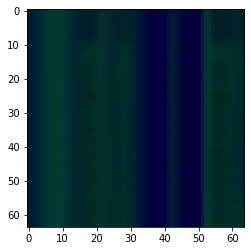

In [25]:
plt.imshow(Data[y == 1][0])

In [20]:
device

device(type='cuda')

In [21]:
'''
Models
'''
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [22]:
'''
Losses
'''
adversarial_loss = nn.BCELoss()
adversarial_loss = adversarial_loss.cuda()

In [23]:
optimizer_G = torch.optim.Adam(generator.parameters(),lr=0.00002, betas=(0.5, 0.999) )
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=0.00002, betas=(0.5, 0.999))

In [24]:
cuda = torch.cuda.is_available()

In [25]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

epochs = 2000

In [30]:
for epoch in tqdm(range(epochs)):
    gLoss = -1
    dLoss = -1
    f1score = float("inf")
    for index, (data, label) in enumerate(dataloader):

        valid = Variable(Tensor(data.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(data.size(0), 1).fill_(0.0), requires_grad=False)

        label = label.to(device)

        real_imgs = Variable(data.type(Tensor))
        optimizer_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (data.shape[0], 100,1,1))))

        gen_imgs = generator(z,label)

        gen_imgs = gen_imgs.to(device)

        g_loss = adversarial_loss(discriminator(gen_imgs,label), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs,label), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(),label), fake)

        d_loss = (real_loss + fake_loss)

        d_loss.backward()

        optimizer_D.step()

        gLoss = g_loss.item()
        dLoss = d_loss.item()

        f1Temp = -(gLoss * dLoss) / (gLoss + dLoss)
        if f1Temp < f1score:
            f1score = f1Temp
            # torch.save(generator.state_dict(),'Models/generator.pth')
    if (epoch+1)%50 == 0:
        print('gLoss ==>',round(gLoss,4))
        print("dLoss ==>",round(dLoss,4))

In [28]:
images = generator(torch.randn(1, 100 , 1 , 1).to(device), torch.tensor([[1]]).to(device))